In [1]:
import pandas as pd
import numpy as np
from math import pi
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from IPython.display import display, Markdown
import time

In [2]:
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
# from sklearn.base import clone

import keras
from keras.models import Model
from keras.models import Sequential
from keras.layers import Convolution1D as Conv1D
from keras.layers import ZeroPadding1D, MaxPooling1D, BatchNormalization, Activation, Dropout, Flatten, Dense

In [163]:
df = pd.read_csv("training_set.csv")
location_df = pd.read_csv("locations.csv")

In [164]:
#check all columns
df_loc = df.join(location_df.set_index('Location'), on='Location')
df_loc.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RISK_MM', 'RainTomorrow', 'lat', 'lon'],
      dtype='object')

In [165]:
# take out test set (2015)
df["Date"] = pd.to_datetime(df['Date'])
df.insert(1, "Year", df["Date"].dt.year, True)
test = df[df.Year == 2015]
train = df[df.Year != 2015]


number of obdervations with rainfall>200mm: 11


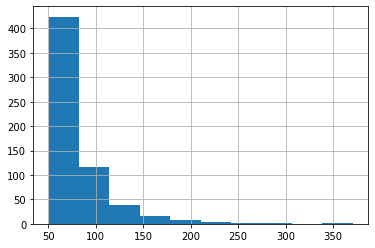

In [122]:
df.Rainfall[df.Rainfall>50].hist()
print()
print("number of obdervations with rainfall>200mm:",len(df.Rainfall[df.Rainfall>200]))

In [166]:
train = train.drop(train[train['Rainfall']> 200].index)

In [10]:
# USEAGE
# Each function takes 'df' as pandas dataframe object and returns the modified dataframe.
# add_locs also takes a datafrane of the locations
# example:
#   data = pd.read_csv("weatherAUS.csv")
#   data = wind_vectors(data)
#   locations = pd.read_csv("lcoations.csv")
#   data = add_locs(data, locations)

import pandas as pd
import numpy as np
import datetime

# add location coordinates
def add_locs(df, location_df):
    return df.join(location_df.set_index('Location'), on='Location')

# convert yes and no strings to binary
def binary_target(df):
    df["RainTomorrow"] = df["RainTomorrow"].replace(('Yes', 'No'), (1, 0))
    df["RainToday"] = df["RainToday"].replace(('Yes', 'No'), (1, 0))
    return df

def wind_vectors(df):
    df['WindGustDir'] = df['WindGustDir'].replace(
        ('N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW','SW','WSW','W','WNW','NW','NNW'),
        (0, 22.5, 45, 67.5, 90, 112.5, 135, 157.5, 180, 202.5, 225, 247.5, 270, 292.5, 315, 337.5)
    )

    df['WindDir9am'] = df['WindDir9am'].replace(
        ('N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW','SW','WSW','W','WNW','NW','NNW'),
        (0, 22.5, 45, 67.5, 90, 112.5, 135, 157.5, 180, 202.5, 225, 247.5, 270, 292.5, 315, 337.5)
    )

    df['WindDir3pm'] = df['WindDir3pm'].replace(
        ('N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW','SW','WSW','W','WNW','NW','NNW'),
        (0, 22.5, 45, 67.5, 90, 112.5, 135, 157.5, 180, 202.5, 225, 247.5, 270, 292.5, 315, 337.5)
    )

    wv = df.pop('WindGustSpeed')
    wd = df.pop('WindGustDir')*np.pi/180
    df['WindGustX'] = wv*np.cos(wd)
    df['WindGustY'] = wv*np.sin(wd)

    wv = df.pop('WindSpeed9am')
    wd = df.pop('WindDir9am')*np.pi/180
    df['Wind9amX'] = wv*np.cos(wd)
    df['Wind9amY'] = wv*np.sin(wd)

    wv = df.pop('WindSpeed3pm')
    wd = df.pop('WindDir3pm')*np.pi/180
    df['Wind3pmX'] = wv*np.cos(wd)
    df['Wind3pmY'] = wv*np.sin(wd)

    return df

def date_to_signal(df):
    data_date = pd.to_datetime(df['Date'])
    timestamp_s = data_date.map(datetime.datetime.timestamp)
    day = 24*60*60
    year = (365.2425)*day
    month = data_date.dt.month
    season = ((month -1)%12 + 3)//3
    df['daysin'] = np.sin(timestamp_s * (2 * np.pi/day))
    df['daycos'] = np.cos(timestamp_s * (2 * np.pi/day))
    df['yearsin'] = np.sin(timestamp_s * (2 * np.pi/year))
    df['yearcos'] = np.cos(timestamp_s * (2 * np.pi/year))
    df['monthsin'] = np.sin((month-1)*(2.*np.pi/12))
    df['monthcos'] = np.cos((month-1)*(2.*np.pi/12))
    df['seasonsin'] = np.sin((month-1)*(2.*np.pi/4))
    df['seasoncos'] = np.cos((month-1)*(2.*np.pi/4))

    return df

def aug_all(df, location_df):
    df = add_locs(df, location_df)
    df = binary_target(df)
    df = date_to_signal(df)
    df = wind_vectors(df)
    return df

In [129]:
# USEAGE
# df should have turned 'Date' column as pd.to_datetime(df['Date'])
# df has inserted a 2nd colum 'Year': df.insert(1, "Year", df["Date"].dt.year, True)
# median = None: this is to preprocess test data that's never seen
# median != None, will return processed df, and medians, powertransform fit, and minmaxsclar fit from training data, 
# They will be used to transform test data.

def preprocess(df, median = None, pt_fit = None, mms_f = None):

    
    ### 1. add lon, lat columns and features engineering
    df = aug_all(df, location_df)
    

    ### 2. drop some column ###
    df.drop("Date",axis=1,inplace=True)
    df.drop("Year",axis=1,inplace=True)
    df.drop("RISK_MM",axis=1,inplace = True)
    #remove highly correlated columns
    df.drop(columns = ["Temp3pm", "Temp9am", "Pressure9am"], axis=1, inplace = True)
    #print('1. columns:', df.columns)
    
    ### 3. define columns ###
    # high missing % columns
    miss_col_30 = ['Sunshine', 'Evaporation', 'Cloud3pm', 'Cloud9am']
    
    # 
    
    # catogorical and numerical columns
    cat_cols = []
    num_cols = []
    other_cols = []

    for each in df.columns:
        if df[each].dtype == "object":
            cat_cols.append(each)
        elif df[each].dtype == "float64":
            num_cols.append(each)
        else:
            other_cols.append(each)

    
    ### 4. data preprocessing ###
    
    # drop columns with too many missing values
    df_clean = df.copy(deep = True)
    df_clean.drop(columns = miss_col_30, axis=1, inplace = True)
    to_remove = miss_col_30
    num_cols = [i for i in num_cols if i not in to_remove]
    
    # Fill missing value with median
    # if this is for training data
    if median == None:
        medians = []
        for k in num_cols:
            df_clean[k].fillna(value=df[k].median(),inplace=True)
            medians.append(df[k].median())
    # # if this is for test data, use the median values of training data
    else: 
        medians = median
        i = 0
        for k in num_cols:
            df_clean[k].fillna(value = medians[i],inplace=True)
            i += 1
        
    # one hot encoder
    df1 = pd.get_dummies(df_clean.Location)
    df_prepared = pd.concat([df_clean, df1], axis=1)
    
    # drop more columns 
    df_prepared.drop(columns = ["Location"],axis=1,inplace=True)
    #print('1. columns:',df_prepared.columns)
    
    # Drop rainfall outliers: only 13 entries, but they stretch the range to almost twice.
    df_prepared = df_prepared.drop(df_prepared[df_prepared['Rainfall']> 200].index)

    
    if pt_fit == None:
        # Power transform 'Rainfall' column that's serious skewed
        a = np.array(df_prepared['Rainfall'].values.tolist()).reshape(-1, 1)
        pt = PowerTransformer(method='yeo-johnson')
        pt_fit = pt.fit(a)
        features_trans = pt_fit.transform(a)
        # df1.skew()
        df_prepared['Rainfall'] = features_trans
    else: 
        a = np.array(df_prepared['Rainfall'].values.tolist()).reshape(-1, 1)
        features_trans = pt_fit.transform(a)
        # df1.skew()
        df_prepared['Rainfall'] = features_trans
    
    #Normalize
    if mms_f == None:
        mms = MinMaxScaler()
        mms_fit = mms.fit(df_prepared)
        df_prepared[df_prepared.columns[:]] = mms_fit.fit_transform(df_prepared)
    else: 
        df_prepared[df_prepared.columns[:]] = mms_fit.fit_transform(df_prepared)

    if median == None:
        return df_prepared, medians, pt_fit, mms_fit
    else:
        return df_prepared
    

In [130]:
# transform traning data
train_df = train.copy(deep=True)
train_df, medians, pt_fit, mms_fit = preprocess(train_df)

In [131]:
train.shape, train_df.shape
#removes 9 outliers

((92410, 25), (92401, 73))

In [189]:
# tranform test data
test_df = test.copy(deep=True)
# use the medians in training set to fill missing values in test days
test_df= preprocess(test, medians)

In [190]:
test.shape, test_df.shape
#removes 2 outliers

((17231, 25), (17229, 73))

# 3. Train Model

In [191]:
X_train = train_df.drop(columns = ["RainTomorrow"], axis = 1)
y_train = train_df["RainTomorrow"]

X_test = test_df.drop(columns = ["RainTomorrow"], axis = 1)
y_test = test_df["RainTomorrow"]

In [136]:
X_train.shape, y_train.shape

((92401, 72), (92401,))

In [137]:
# list of columns
l = X_train.columns

In [193]:
X_test.shape, y_test.shape

((17229, 72), (17229,))

### Different CV methods

# PCA

In [139]:
from sklearn.decomposition import PCA

pca = PCA(0.99, whiten=True)
pac_train = pca.fit(X_train)
principalComponents = pac_train.transform(X_train)
#fit-train, transform-test
X_train_PCA = pd.DataFrame(data = principalComponents)
X_train_PCA

,0,1,2,3,4,5,6,7,8,9,...,49,50,51,52,53,54,55,56,57,58
0,1.346039,0.178185,0.735945,0.083805,1.381676,-0.710627,-0.309919,0.528818,-0.678838,0.903599,...,-0.182973,-0.147009,0.039386,1.375426,0.918660,3.296175,0.146573,0.337501,-0.945428,0.526036
1,1.394591,-0.525180,0.753263,0.057371,1.397473,-0.624881,-0.352933,0.686289,-0.980180,0.568253,...,-0.047650,-0.136383,-0.006629,0.979328,-0.509692,-0.095468,-0.262022,-0.428107,0.067683,-0.360811
2,1.415153,-0.508081,0.731580,0.068475,1.392415,-0.516084,-0.239965,0.685719,-0.849579,0.158131,...,-0.047097,0.037584,0.054666,1.765386,-0.559218,-0.233894,-0.357974,-0.879403,0.400896,-0.719876
3,1.421197,-0.574921,0.704480,0.052249,1.382108,-0.408526,-0.114401,0.681554,-0.994170,0.007929,...,0.067416,0.295496,-0.377593,-0.718024,-0.960554,0.411307,-0.188331,-0.279341,-0.179772,-0.526219
4,1.368545,0.380595,0.652472,0.090313,1.360313,-0.598356,-0.065687,0.319157,-0.203650,1.115444,...,-0.209442,-0.306570,0.024323,0.877367,1.597874,4.081338,0.344203,0.247796,-0.675862,0.542303
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92396,-0.934133,-0.843946,-0.414420,-0.182381,-1.353151,1.035746,-0.350931,-0.780558,-1.450700,-0.592574,...,0.241559,0.315049,-0.238651,-1.064289,-2.649759,1.305398,2.703184,-0.907444,5.893295,7.606908
92397,-0.925669,-0.875338,-0.387281,-0.168957,-1.342582,1.143385,-0.347984,-0.629060,-1.678406,-0.555519,...,0.234309,0.203279,-0.191137,-0.919217,-2.895269,1.393323,2.606934,-1.052443,5.972626,7.388041
92398,-0.928308,-0.869638,-0.366381,-0.164525,-1.331580,1.118689,-0.407777,-0.549118,-1.776255,0.096783,...,0.145405,-0.224194,0.024117,-0.424785,-2.609629,1.297137,2.726344,-0.594834,5.548255,7.953422
92399,-0.919388,-0.868083,-0.354308,-0.157212,-1.328202,1.184531,-0.355380,-0.545134,-1.762606,0.330099,...,0.124111,-0.466485,0.123070,-0.326946,-2.534298,1.250153,2.674129,-0.825884,5.795153,7.735508


# use 15 most Important features based on coefficient

In [146]:
def cv_important_features(clf, clf_coef= None):
    
    # if random forest
    if clf_coef:
        coef = clf.feature_importances_
        coef = list(coef.reshape(coef.shape[0],))
    else: 
        coef = np.round(clf.coef_,2)
        coef = list(coef.reshape(coef.shape[1],))
    l = X_train.columns

    d = {} 
    for key in l: 
        for value in coef: 
            d[key] = value 
            coef.remove(value) 
            break

    predictor_coef = {k: v for k, v in sorted(d.items(), reverse=True, key=lambda item: abs(item[1]))}
    # select top 1o features 
    impt_15f= [k for k,v in predictor_coef.items()][:15]
    impt_10f = impt_15f[:10]
    
    # compared wiht cv using top 10 features
    start_time_sgd_impt = time.time()
    scores_10impt = cross_val_score(clf, X_train[impt_10f], y_train, cv=5, scoring="accuracy")
    print("Took  %s seconds  for 5-fold CV using 10 most important features" % round((time.time() - start_time_sgd_impt),2))
    print("cv scores using 15 most important features:",scores_10impt,)
    avg_scores_10 = scores_10impt.mean()
    print('Average score:', avg_scores_10)
    print()
    
    # compared wiht cv using top 15 features
    start_time_sgd_impt = time.time()
    scores_impt = cross_val_score(clf, X_train[impt_15f], y_train, cv=5, scoring="accuracy")
    print("Took  %s seconds  for 5-fold CV using 15 most important features" % round((time.time() - start_time_sgd_impt),2))
    print("cv scores using 15 most important features:",scores_10impt,)
    avg_scores = scores_impt.mean()
    print('Average score:', avg_scores)
    print()
    
    # compared wiht cv using all features
    start_time = time.time()
    scores_all = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
    print("Took %s seconds for 5-fold CV using all feature" % round((time.time() - start_time),2))
    print("cv scores using all features:",scores_all)
    avg_scores_all = scores_all.mean()
    print('Average score:', avg_scores_all)
    print()
    
    diff = round((avg_scores - avg_scores_all)*100,2)
    diff10 = round((avg_scores_10 - avg_scores)*100,2)
    if (diff>=0):
        print('Using most important 15 features IMPROVED average CV accuracy by '+str(diff)+' %')
        if  diff10 > 0:
            print('AND using most important 10 features IMPROVED average CV accuracy by '+str(diff10+diff)+' %')    
    else:
        print('Using most important 15 features decresed average CV accuracy by '+str(diff)+' %')
    
    return predictor_coef, impt_15f, scores_impt, scores_all

In [147]:
predictor_coef_sgd, impt_15f_sgd, scores_impt_sgd, scores_all_sgd = cv_important_features(sgd_clf)

Took  0.77 seconds  for 5-fold CV using 10 most important features
cv scores using 15 most important features: [0.82733618 0.81168831 0.83333333 0.82900433 0.84015152]
Average score: 0.8283027344568928

Took  0.88 seconds  for 5-fold CV using 15 most important features
cv scores using 15 most important features: [0.82733618 0.81168831 0.83333333 0.82900433 0.84015152]
Average score: 0.8305321552894736

Took 2.07 seconds for 5-fold CV using all feature
cv scores using all features: [0.82327796 0.80286797 0.76650433 0.76850649 0.84334416]
Average score: 0.8009001809744465

Using most important 15 features IMPROVED average CV accuracy by 2.96 %


# Logistic Regression

In [168]:
clf_lr = LogisticRegression(C=1, penalty='l1', solver='liblinear')
clf_lr.fit(X_train, y_train)
#Predict Output
y_pred_lr= clf_lr.predict(X_train) 
accuracy_score(y_train,y_pred_lr)

0.83986104046493

In [197]:
# see the features removed by lasso
sel_ = SelectFromModel(LogisticRegression(C=1, penalty='l1', solver='liblinear')).fit(X_train, y_train)
lasso_removed_feats = X_train.columns[(sel_.estimator_.coef_ == 0).ravel().tolist()]
lasso_removed_feats

Index(['Cairns', 'MountGambier', 'Newcastle'], dtype='object')

In [ ]:
# X_train_selected = sel_.transform(X_train)
# X_test_selected = sel_.transform(X_test)
# X_train_selected.shape, X_test_selected.shape

In [171]:
start_time = time.time()
scores = cross_val_score(clf_lr, X_train, y_train, cv=5, scoring='accuracy')
print("Took %s seconds for 5-fold CV using all feature" % round((time.time() - start_time),2))
scores

Took 54.71 seconds for 5-fold CV using all feature


array([0.82344029, 0.74832251, 0.76455628, 0.75719697, 0.84123377])

In [172]:
scores.mean()

0.786949962767424

In [169]:
predictor_coef_lr, impt_15f_lr, scores_impt_lr, scores_all_lr = cv_important_features(clf_lr)

Took  8.32 seconds  for 5-fold CV using 10 most important features
cv scores using 15 most important features: [0.82755262 0.81201299 0.8387987  0.83019481 0.84193723]
Average score: 0.8300992689110215

Took  11.29 seconds  for 5-fold CV using 15 most important features
cv scores using 15 most important features: [0.82755262 0.81201299 0.8387987  0.83019481 0.84193723]
Average score: 0.8354022617355229

Took 53.81 seconds for 5-fold CV using all feature
cv scores using all features: [0.82647043 0.74810606 0.76450216 0.75795455 0.84074675]
Average score: 0.7875559905797717

Using most important 15 features IMPROVED average CV accuracy by 4.78 %


In [170]:
impt_15f_lr

['Humidity3pm',
 'Pressure3pm',
 'MinTemp',
 'Wind9amY',
 'Wind9amX',
 'daysin',
 'lat',
 'Wind3pmX',
 'daycos',
 'Wind3pmY',
 'yearcos',
 'WindGustY',
 'Wollongong',
 'WindGustX',
 'Rainfall']

# SVC

In [183]:
# small C means high tolerance of misclassification
clf_svc = svm.SVC(kernel='linear', C=1)

clf_svc.fit(X_train, y_train)
#Predict Output
predicted= clf_svc.predict(X_train) 
accuracy_score(y_train,y_pred)
# start_time = time.time()
# scores_svc = cross_val_score(clf_svc, X_train, y_train, cv=3, scoring='accuracy')
# print("SVC took--- %s seconds ---" % round((time.time() - start_time),2))
# scores_svc

0.8420471639917317

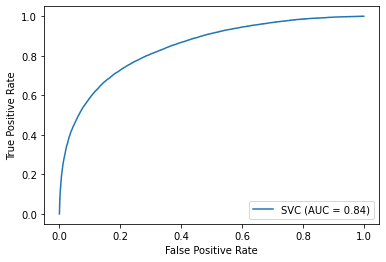

In [400]:
from sklearn.metrics import plot_roc_curve

svc_disp = plot_roc_curve(clf, X_train, y_train)
plt.show()

In [373]:
cm = confusion_matrix(y_train, predicted)
cm

array([[68741,  3012],
       [11782,  8875]])

In [184]:
predictor_coef_svc, impt_15f_svc, scores_impt_svc, scores_all_svc = cv_important_features(clf_svc)

Took  323.01 seconds  for 5-fold CV using 10 most important features
cv scores using 15 most important features: [0.82814783 0.81060606 0.83874459 0.83095238 0.84090909]
Average score: 0.8298719897421266

Took  361.04 seconds  for 5-fold CV using 15 most important features
cv scores using 15 most important features: [0.82814783 0.81060606 0.83874459 0.83095238 0.84090909]
Average score: 0.8359325501257755

Took 1401.88 seconds for 5-fold CV using all feature
cv scores using all features: [0.8268492  0.7538961  0.76920996 0.75692641 0.8387987 ]
Average score: 0.7891360730606441

Using most important 15 features IMPROVED average CV accuracy by 4.68 %


# KNN

In [837]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
#Predict Output
y_pred_knn= knn.predict(X_train) 
accuracy_score(y_train,y_pred_knn)

0.8711070230494535

In [372]:
cm = confusion_matrix(y_train, y_pred_knn)
cm

array([[69611,  2142],
       [ 7515, 13142]])

In [832]:
# # This one used 3 neighbors, overfit
# start_time = time.time()

# scores = cross_val_score(knn3, X_train, y_train, cv=5, scoring='accuracy')

# print("KNN took--- %s seconds ---" % round((time.time() - start_time),2))
# scores

KNN took--- 333.43 seconds ---


array([0.80721783, 0.76674602, 0.74770047, 0.7544097 , 0.82177254])

In [839]:
start_time = time.time()

scores_5 = cross_val_score(knn, X_train[], y_train, cv=3, scoring='accuracy')

print("KNN took--- %s seconds ---" % round((time.time() - start_time),2))
scores_5

KNN took--- 277.05 seconds ---


array([0.80346708, 0.75820537, 0.81602441])

In [203]:
# # use 15 most important features
# start_time = time.time()

# scores_5 = cross_val_score(knn, X_train[impt_15f_sgd], y_train, cv=3, scoring='accuracy')

# print("KNN took--- %s seconds ---" % round((time.time() - start_time),2))
# scores_5

# Random Forest

In [173]:
from sklearn.ensemble import RandomForestClassifier

#random forest
rfc=RandomForestClassifier(random_state=42, max_features='auto', n_estimators= 200, max_depth=8, criterion='gini')

rfc.fit(X_train, y_train)
y_pred=rfc.predict(X_train)
accuracy_score(y_train,y_pred)

0.8420471639917317

In [174]:
cm = confusion_matrix(y_train, y_pred)
cm

array([[70305,  1448],
       [13147,  7501]])

In [784]:
start_time = time.time()
scores_rfc = cross_val_score(rfc, X_train, y_train, cv=5, scoring='accuracy')
print("RF took--- %s seconds ---" % round((time.time() - start_time),2))
scores_rfc

RF took--- 64.56 seconds ---


array([0.82653392, 0.82739963, 0.81895899, 0.79444865, 0.8336219 ])

In [804]:
scores_rfc.mean()

0.8201926198463371

In [175]:
predictor_coef_rfc, impt_15f_rfc, scores_impt_rfc, scores_all_rfc = cv_important_features(rfc, 1)

Took  55.25 seconds  for 5-fold CV using 10 most important features
cv scores using 15 most important features: [0.8414588  0.8288961  0.84145022 0.84312771 0.84431818]
Average score: 0.8398502006623861

Took  53.64 seconds  for 5-fold CV using 15 most important features
cv scores using 15 most important features: [0.8414588  0.8288961  0.84145022 0.84312771 0.84431818]
Average score: 0.8388761676611359

Took 59.39 seconds for 5-fold CV using all feature
cv scores using all features: [0.82863481 0.82862554 0.8142316  0.77575758 0.83306277]
Average score: 0.8160624606621848

Using most important 15 features IMPROVED average CV accuracy by 2.28 %
AND using most important 10 features IMPROVED average CV accuracy by 2.38 %


# SGD classifier - FAST!

#Stochastic Gradient Descent (SGD) classifier. This classifier has the advantage of being capable of handling very large datasets efficiently. This is in part because SGD deals with training instances independently, one at a time (which also makes SGD well suited for online learning).

In [141]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score

sgd_clf = SGDClassifier(random_state=42)

sgd_clf.fit(X_train, y_train)
y_pred_sgd=sgd_clf.predict(X_train)
accuracy_score(y_train,y_pred_sgd)

0.8386813995519529

In [148]:
predictor_coef_sgd, impt_15f_sgd, scores_impt_sgd, scores_all_sgd = cv_important_features(sgd_clf)

Took  0.6 seconds  for 5-fold CV using 10 most important features
cv scores using 15 most important features: [0.82733618 0.81168831 0.83333333 0.82900433 0.84015152]
Average score: 0.8283027344568928

Took  0.8 seconds  for 5-fold CV using 15 most important features
cv scores using 15 most important features: [0.82733618 0.81168831 0.83333333 0.82900433 0.84015152]
Average score: 0.8305321552894736

Took 1.83 seconds for 5-fold CV using all feature
cv scores using all features: [0.82327796 0.80286797 0.76650433 0.76850649 0.84334416]
Average score: 0.8009001809744465

Using most important 15 features IMPROVED average CV accuracy by 2.96 %


# Select best features

In [ ]:
clf = Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1"))),
  ('classification', RandomForestClassifier())
])
clf.fit(X, y)

# based on coeffients

In [198]:
f_top15 = pd.DataFrame(
    {'LReg': impt_15f_lr, 
     'SVC': impt_15f_svc,
     'RamF': impt_15f_rfc,
     'SGD':impt_15f_sgd
    })
f_top15

,LReg,SVC,RamF,SGD
0,Humidity3pm,Humidity3pm,Humidity3pm,Humidity3pm
1,Pressure3pm,Pressure3pm,Rainfall,Pressure3pm
2,MinTemp,Wind9amY,RainToday,Wind9amY
3,Wind9amY,Wind3pmY,Humidity9am,MinTemp
4,Wind9amX,Wind9amX,Pressure3pm,Wind3pmY
5,daysin,MinTemp,MaxTemp,Wind9amX
6,lat,Humidity9am,WindGustY,Humidity9am
7,Wind3pmX,Wind3pmX,WindGustX,Wind3pmX
8,daycos,Wollongong,MinTemp,Wollongong
9,Wind3pmY,Townsville,Wind9amX,Townsville


### 2. select features based on importance weights.

In [233]:
from sklearn.feature_selection import RFE

# n_features_to_select=1 to rank all features
selector = RFE(sgd_clf, n_features_to_select=1, step=1)
selector = selector.fit(X_train, y_train)
# selector.support_

In [200]:
from sklearn.feature_selection import RFE

# n_features_to_select=1 to rank all features
selector = RFE(sgd_clf, n_features_to_select=1, step=1)
selector = selector.fit(X_train, y_train)

rank1 = selector.ranking_

d1 = {} 
for key in l: 
    for value in rank1: 
        d1[key] = value 
        np.delete(rank1, np.argwhere(rank1 == 6))
        break

predictor_rank = {k: v for k, v in sorted(d1.items(), reverse=True, key=lambda item: abs(item[1]))}
# select top 10 features 
impt_15_rfe= [k for k,v in predictor_rank.items()][:15]
f_top15['RFE_sgd'] = impt_15_rfe

# Most important features

In [202]:
f_top15

,LReg,SVC,RamF,SGD,RFE_sgd
0,Humidity3pm,Humidity3pm,Humidity3pm,Humidity3pm,MinTemp
1,Pressure3pm,Pressure3pm,Rainfall,Pressure3pm,MaxTemp
2,MinTemp,Wind9amY,RainToday,Wind9amY,Rainfall
3,Wind9amY,Wind3pmY,Humidity9am,MinTemp,Humidity9am
4,Wind9amX,Wind9amX,Pressure3pm,Wind3pmY,Humidity3pm
5,daysin,MinTemp,MaxTemp,Wind9amX,Pressure3pm
6,lat,Humidity9am,WindGustY,Humidity9am,RainToday
7,Wind3pmX,Wind3pmX,WindGustX,Wind3pmX,lat
8,daycos,Wollongong,MinTemp,Wollongong,lon
9,Wind3pmY,Townsville,Wind9amX,Townsville,daysin


In [234]:
def longestCommonFeatures(lists):
    
    l1 = set(lists[0])
    ppl = {}
    for l in lists[1:]:
        common = set(l).intersection(l1)

        l1 = common
        
        for i in l:
            if i not in ppl:
                ppl[i] = 1
            else:
                ppl[i] += 1
                
    ppl = {k: v for k, v in sorted(ppl.items(), reverse=True, key=lambda item: abs(item[1]))}
    
    return common, ppl

lists = [impt_15f_lr, impt_15f_svc,impt_15f_rfc,impt_15f_sgd, impt_15_rfe]
common, ppl = longestCommonFeatures(lists)
common, ppl

({'Humidity3pm', 'MinTemp', 'Pressure3pm', 'Rainfall'},
 {'Humidity3pm': 4,
  'Pressure3pm': 4,
  'MinTemp': 4,
  'Humidity9am': 4,
  'Rainfall': 4,
  'Wind9amY': 3,
  'Wind9amX': 3,
  'Wind3pmX': 3,
  'WindGustX': 3,
  'yearcos': 3,
  'Wind3pmY': 2,
  'Wollongong': 2,
  'Townsville': 2,
  'NorahHead': 2,
  'RainToday': 2,
  'MaxTemp': 2,
  'lon': 2,
  'lat': 2,
  'daycos': 2,
  'Albany': 1,
  'WindGustY': 1,
  'AliceSprings': 1,
  'daysin': 1,
  'yearsin': 1,
  'monthsin': 1,
  'monthcos': 1})

### 3. select features based on importance weights.
##### same with 1st method, it uses coefficients

In [ ]:
# from sklearn.feature_selection import SelectFromModel
# from sklearn.linear_model import LogisticRegression

# selector = SelectFromModel(estimator= sgd_clf).fit(X_train, y_train)
# selector.estimator_.coef_

In [ ]:
# selector.threshold_

In [ ]:
# selector.get_support()

In [235]:
# selector.transform(X)

#### use important features saves time and doesn't lower accuracy

## Use a whole year as the validation set

In [167]:
train_df1 = pd.concat([train[['Year']], train_df], axis=1)
train_df1


# 2015 is held out as the test set, other years will be held out one by one as validation set.
cv_score_year = []
for y in train_df1.Year[(train_df1.Year != 2015)].unique():

    train1 = train_df1 [(train_df1.Year != 2015)&(train_df1 .Year != y)]
    valid = train_df1 [train_df1 .Year == y]

    X_train1 = train1.drop(columns = ["RainTomorrow", "Year"], axis = 1)
    y_train1 = train1["RainTomorrow"]

    X_valid = valid.drop(columns = ["RainTomorrow", "Year"], axis=1)
    y_valid = valid["RainTomorrow"]
          
    sgd_clf.fit(X_train1, y_train1)
    y_pred_sgd1=rfc.predict(X_valid)
    score = round(accuracy_score(y_valid,y_pred_sgd1),2)
    cv_score_year.append(score)
    print("validation accuracy of year",y,':',score)

validation accuracy of year 2008 : 0.82
validation accuracy of year 2009 : 0.85
validation accuracy of year 2010 : 0.83
validation accuracy of year 2011 : 0.83
validation accuracy of year 2013 : 0.85
validation accuracy of year 2014 : 0.85
validation accuracy of year 2017 : 0.84
validation accuracy of year 2007 : 0.74


In [654]:
not much difference

## Different accuracy score 

# CNN

In [351]:
measurements = train.copy(deep=True)

In [352]:
x = measurements.drop(columns = ["RainTomorrow", "Month", "Year"], axis = 1)
y = measurements["RainTomorrow"]

In [353]:
x = np.array(x[:])
x.shape

(92410, 72)

In [354]:
# validation set
from sklearn.model_selection import train_test_split
x_train, x_test, Y_train, Y_test = train_test_split(x, y, test_size = 0.2,random_state = 120)

In [355]:
Y_train.shape, Y_test.shape

((73928,), (18482,))

In [356]:
x_train.shape, x_test.shape

((73928, 72), (18482, 72))

In [357]:
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],1)

In [358]:
x_train.shape, x_test.shape

((73928, 72, 1), (18482, 72, 1))

In [359]:
Y_train = np.asarray(Y_train).astype('float32').reshape((-1,1))
Y_test = np.asarray(Y_test).astype('float32').reshape((-1,1))

In [360]:
Y_train.shape, Y_test.shape

((73928, 1), (18482, 1))

In [361]:
batch_size = 256
num_classes = 1
epochs = 100
input_shape=(x_train.shape[1],1)

In [333]:
model = Sequential()
intput_shape=(x_train.shape[1], 1)
model.add(Conv1D(128, kernel_size=3,padding = 'same',activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=(2)))
model.add(Conv1D(128,kernel_size=3,padding = 'same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=(2)))
model.add(Flatten())
model.add(Dense(64, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='sigmoid'))
model.summary()

Model: "sequential_73"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 72, 128)           512       
_________________________________________________________________
batch_normalization_18 (Batc (None, 72, 128)           512       
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 36, 128)           0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 36, 128)           49280     
_________________________________________________________________
batch_normalization_19 (Batc (None, 36, 128)           512       
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 18, 128)           0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 2304)            

In [334]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [370]:
hist_rnn = model.fit(x_train, Y_train, validation_data=(x_test, Y_test), epochs=15)

Epoch 1/15
2311/2311 [==============================] - 27s 12ms/step - loss: 0.3455 - accuracy: 0.8529 - val_loss: 0.3448 - val_accuracy: 0.8527
Epoch 2/15
2311/2311 [==============================] - 26s 11ms/step - loss: 0.3453 - accuracy: 0.8528 - val_loss: 0.3444 - val_accuracy: 0.8492
Epoch 3/15
2311/2311 [==============================] - 28s 12ms/step - loss: 0.3444 - accuracy: 0.8524 - val_loss: 0.3462 - val_accuracy: 0.8509
Epoch 4/15
2311/2311 [==============================] - 29s 13ms/step - loss: 0.3455 - accuracy: 0.8527 - val_loss: 0.3629 - val_accuracy: 0.8480
Epoch 5/15
2311/2311 [==============================] - 30s 13ms/step - loss: 0.3445 - accuracy: 0.8533 - val_loss: 0.3491 - val_accuracy: 0.8503
Epoch 6/15
2311/2311 [==============================] - 29s 12ms/step - loss: 0.3440 - accuracy: 0.8537 - val_loss: 0.3485 - val_accuracy: 0.8496
Epoch 7/15
2311/2311 [==============================] - 27s 11ms/step - loss: 0.3434 - accuracy: 0.8545 - val_loss: 0.3489 -

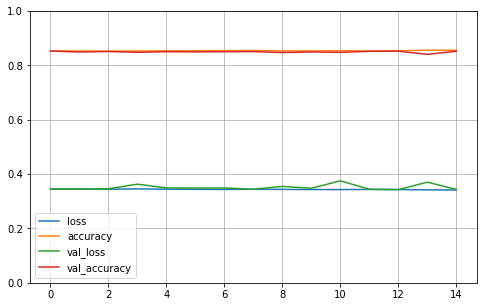

In [371]:
pd.DataFrame(hist_rnn.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

# DNN

In [314]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[72,]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [315]:
history = model.fit(x_train, Y_train, validation_data=(x_test, Y_test), epochs=30)

Epoch 1/30
2022/2022 [==============================] - 2s 993us/step - loss: 0.4670 - accuracy: 0.7947 - val_loss: 0.4212 - val_accuracy: 0.8180
Epoch 2/30
2022/2022 [==============================] - 2s 954us/step - loss: 0.3994 - accuracy: 0.8291 - val_loss: 0.3883 - val_accuracy: 0.8349
Epoch 3/30
2022/2022 [==============================] - 2s 1ms/step - loss: 0.3810 - accuracy: 0.8389 - val_loss: 0.3784 - val_accuracy: 0.8398
Epoch 4/30
2022/2022 [==============================] - 2s 880us/step - loss: 0.3758 - accuracy: 0.8411 - val_loss: 0.3761 - val_accuracy: 0.8394
Epoch 5/30
2022/2022 [==============================] - 2s 819us/step - loss: 0.3737 - accuracy: 0.8407 - val_loss: 0.3751 - val_accuracy: 0.8381
Epoch 6/30
2022/2022 [==============================] - 2s 810us/step - loss: 0.3719 - accuracy: 0.8410 - val_loss: 0.3730 - val_accuracy: 0.8400
Epoch 7/30
2022/2022 [==============================] - 2s 903us/step - loss: 0.3703 - accuracy: 0.8418 - val_loss: 0.3707 - v

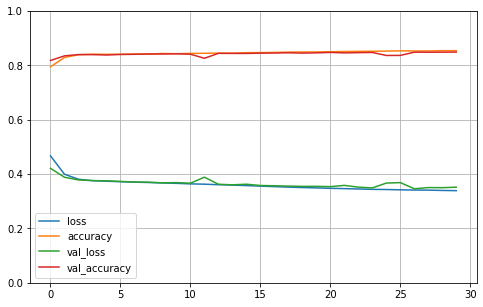

In [369]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

# Test

In [29]:
X_test.shape, y_test.shape

In [ ]:
df = pd.read_csv("training_set.csv",index_col="Date",parse_dates=["Datetime"])
df = df.sort_index()
df

# label imbalance
#If the training set was very skewed, with some classes being overrepresented and others underrepresented, it would be useful to set the class_weight argument when calling the fit() method, which would give a larger weight to underrepresented classes and a lower weight to overrepresented classes.

# Reference:
##### circular data transform: http://blog.davidkaleko.com/feature-engineering-cyclical-features.html  
##### Australian weather https://www.finalword.com/map-weather-of-australia/